In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns
from collections import Counter
import datetime
import re

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Business Use Case
- The goal of this project is to analyze the past demand of different products, approach to develop forecasting mechanisms for future, evaluate & interpret results based on the analysis. 
- Based on this analysis, we want to be able to develop intuition about the business.
- We also want to assess the different approaches taken, different techniques applied and make inferences about the drawbacks of the failed attempts and note the challenges faced during this.

### I. Reading the data for our demand forecasting

In [2]:
DATAPATH = '../data/CASE_STUDY_FINAL.csv'

In [3]:
data = pd.read_csv(DATAPATH)
data.head(3)

,Date,SKU_mkt,Brand ID,Units,PPC Orders,PPC Cost,Organic
0,1/1/17,MODLB01GR1_US,1,1,1,($7.30),0
1,1/1/17,MODSSBL_US,1,9,0,($6.83),9
2,1/1/17,MODLB01GR2_US,1,8,1,($1.31),7


In [4]:
data.shape

(266500, 7)

### II. Exploring the dataset

Some observations we make on the dataset are:
1. First, we check if our data has any nulls or NaNs and fortunately, we don't observe any null values in our dataset.
2. The data we have has 483 different SKUs i.e. different products spread across 50 brands.
3. We observe that there are ~5000 records that have have Organic units with negative values. This could be an issue that must have occurred while recording data, hence we will remove these records for a cleaner dataset in the preprocessing section of our analysis.
4. We then want to just look at how much spend is done via PPC costs in our entire dataset. We see that this is about 4.9MM dollars which quite a lot of expenditure on just PPC ads but this is spread across multiple brands.
5. We see that with the 50 unique brands, on an average there are approximately 10 SKUs associate with 1 Brand ID. Maximum count of SKUs for a brand is 53.

In [5]:
data.isna().sum()

Date          0
SKU_mkt       0
Brand ID      0
Units         0
PPC Orders    0
PPC Cost      0
Organic       0
dtype: int64

In [6]:
data.isnull().sum()

Date          0
SKU_mkt       0
Brand ID      0
Units         0
PPC Orders    0
PPC Cost      0
Organic       0
dtype: int64

In [7]:
data['SKU_mkt'].nunique(), data['Brand ID'].nunique()

(483, 50)

In [8]:
print(len(data[data['Organic'] < 0]))

4990


In [9]:
data.groupby(['Brand ID'])['SKU_mkt'].nunique().mean(), data.groupby(['Brand ID'])['SKU_mkt'].nunique().max()

(9.8, 53)

### III. Preprocessing the dataset

1. *PPC Cost column* - In order to use this feature for future analysis, modeling & predictions we convert this feature to a numeric value by excluding the dollar ($) sign, commas and parantheses.
2. *Date column* - We want to ensure that our Date feature is in pandas datetime format. We also fetch year, month & day from this datetime feature to be used as additional features for modeling & analysis.
3. *Organic column* - Dropping records which contain negative values. On doing this, we observe that the mean number of Units/Organic orders, which suggests that these few records don't have a high impact on our mean value of Units ordered.

#### 1. Processing PPC Cost

In [10]:
def preprocess_ppccost(cost_text):
    string_cost = re.sub('[,$()]','',cost_text)
    float_cost = float(string_cost)
    return float_cost

In [11]:
data['Processed_PPC Cost'] = data['PPC Cost'].apply(preprocess_ppccost)
data.head(3)

,Date,SKU_mkt,Brand ID,Units,PPC Orders,PPC Cost,Organic,Processed_PPC Cost
0,1/1/17,MODLB01GR1_US,1,1,1,($7.30),0,7.30
1,1/1/17,MODSSBL_US,1,9,0,($6.83),9,6.83
2,1/1/17,MODLB01GR2_US,1,8,1,($1.31),7,1.31


#### 2. Processing Date

In [12]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

data.head(3)

,Date,SKU_mkt,Brand ID,Units,PPC Orders,PPC Cost,Organic,Processed_PPC Cost,Year,Month,Day
0,2017-01-01,MODLB01GR1_US,1,1,1,($7.30),0,7.30,2017,1,1
1,2017-01-01,MODSSBL_US,1,9,0,($6.83),9,6.83,2017,1,1
2,2017-01-01,MODLB01GR2_US,1,8,1,($1.31),7,1.31,2017,1,1


In [13]:
data.describe()

,Brand ID,Units,PPC Orders,Organic,Processed_PPC Cost,Year,Month,Day
count,266500.000000,266500.000000,266500.000000,266500.000000,266500.000000,266500.000000,266500.000000,266500.000000
mean,13.370863,20.714559,2.600931,18.113629,20.056141,2018.368555,6.962563,15.703054
std,11.493332,48.484177,11.280347,43.101612,91.094095,0.739624,3.462034,8.815468
min,1.000000,0.000000,0.000000,-125.000000,0.000000,2017.000000,1.000000,1.000000
25%,5.000000,2.000000,0.000000,2.000000,0.000000,2018.000000,4.000000,8.000000
50%,11.000000,7.000000,0.000000,6.000000,0.000000,2018.000000,7.000000,16.000000
75%,18.000000,20.000000,0.000000,18.000000,5.760000,2019.000000,10.000000,23.000000
max,50.000000,6947.000000,937.000000,6947.000000,6052.670000,2020.000000,12.000000,31.000000


#### 3. Processing Organic

In [14]:
data = data[data['Organic'] >= 0].reset_index(drop=True)
print(data.shape)
data.head(3)

(261510, 11)


,Date,SKU_mkt,Brand ID,Units,PPC Orders,PPC Cost,Organic,Processed_PPC Cost,Year,Month,Day
0,2017-01-01,MODLB01GR1_US,1,1,1,($7.30),0,7.30,2017,1,1
1,2017-01-01,MODSSBL_US,1,9,0,($6.83),9,6.83,2017,1,1
2,2017-01-01,MODLB01GR2_US,1,8,1,($1.31),7,1.31,2017,1,1


In [15]:
data.describe()

,Brand ID,Units,PPC Orders,Organic,Processed_PPC Cost,Year,Month,Day
count,261510.000000,261510.000000,261510.000000,261510.000000,261510.000000,261510.000000,261510.000000,261510.000000
mean,13.376483,20.986612,2.456545,18.530068,18.985815,2018.358545,6.947662,15.702233
std,11.505150,48.882933,11.164385,43.396738,90.139766,0.739918,3.459448,8.812994
min,1.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000
25%,5.000000,2.000000,0.000000,2.000000,0.000000,2018.000000,4.000000,8.000000
50%,11.000000,7.000000,0.000000,6.000000,0.000000,2018.000000,7.000000,16.000000
75%,18.000000,21.000000,0.000000,18.000000,4.690000,2019.000000,10.000000,23.000000
max,50.000000,6947.000000,937.000000,6947.000000,6052.670000,2020.000000,12.000000,31.000000


In [16]:
data['Processed_PPC Cost'].sum()

4964980.57

### IV. Preparing dataset before applying forecasting techniques

- As we saw earlier, our dataset consists of 50 unique brands. Each SKU belong to a unique brand has its own timeseries. However, for ensuring that we have enough dataset for our forecasts of each of these SKUs, we begin by handling our dataset in two ways:
    1. Our first approach is to develop a dataset as a single timeseries, by summing up Units ordered & PPC Cost for all SKUs on a particular date. Though this may not be the best approach, it can be used to see the general ordering pattern over time. We can also see if there is any upward or downward trend in the units ordered, or if there's any seasonal jumps or plummets in the quantity of orders.
    2. Another approach is to develop a dataset with timeseries for each unique Brand ID. In the sense of a business, an intuitive way is to think that a particular brand selling may be 10 or 15 different SKUs. And, that SKUs under the same brand are 'similar' in industry, features/products that they are selling, target the similar consumer base, could have similar marketing strategy and could have similar observations for PPC orders & costs.
    3. Then we create training & test sets from each of these two datasets - a. combined timeseries & b. brand-wise timeseries for our forecast analysis. 

#### 1. Creating a combined timeseries over all SKUs & brands 

In [17]:
combined_dataset = data.groupby(['Date'])['Units','Processed_PPC Cost'].sum().reset_index()
combined_dataset['Year'] = combined_dataset['Date'].dt.year
combined_dataset['Month'] = combined_dataset['Date'].dt.month
combined_dataset['Day'] = combined_dataset['Date'].dt.day

combined_dataset.head(3)

,Date,Units,Processed_PPC Cost,Year,Month,Day
0,2017-01-01,340,15.44,2017,1,1
1,2017-01-02,477,23.66,2017,1,2
2,2017-01-03,437,17.12,2017,1,3


In [18]:
combined_dataset = combined_dataset.sort_values(by='Date')

#### 2. Creating a brand-wise timeseries over all SKUs belonging to that brand

In [19]:
def prepare_brand_dataset(input_df):
    brand_df = input_df.groupby(['Brand ID','Date'])[['Units','Processed_PPC Cost']].sum().reset_index()
    brand_df['Year'] = brand_df['Date'].dt.year
    brand_df['Month'] = brand_df['Date'].dt.month
    brand_df['Day'] = brand_df['Date'].dt.day
    dataset = {}
    for id in brand_df['Brand ID'].unique():
        dataset[id] = brand_df[brand_df['Brand ID'] == id][['Date','Year','Month','Day','Units','Processed_PPC Cost']]
    return dataset

brands_dataset = prepare_brand_dataset(data)
print("Total number of items in this dataset is:",len(brands_dataset)," which is the number of unique Brand IDs in our dataset")

Total number of items in this dataset is: 50  which is the number of unique Brand IDs in our dataset


In [20]:
# For Brand ID = 1, few records from the dataframe
brands_dataset.get(1).tail()

,Date,Year,Month,Day,Units,Processed_PPC Cost
1097,2020-01-08,2020,1,8,30,14.49
1098,2020-01-09,2020,1,9,36,18.10
1099,2020-01-10,2020,1,10,27,6.36
1100,2020-01-11,2020,1,11,15,7.35
1101,2020-01-12,2020,1,12,16,0.00


#### 3. Train-test split into 90:10

##### a. combined dataset

In [21]:
combined_train_set, combined_test_set = np.split(combined_dataset, [int(0.90 * len(combined_dataset))])
combined_train_set.tail(3)

,Date,Units,Processed_PPC Cost,Year,Month,Day
993,2019-09-21,6434,14046.42,2019,9,21
994,2019-09-22,8429,17182.75,2019,9,22
995,2019-09-23,8365,14646.92,2019,9,23


In [22]:
combined_test_set.head(3)

,Date,Units,Processed_PPC Cost,Year,Month,Day
996,2019-09-24,8259,14770.16,2019,9,24
997,2019-09-25,8018,12982.28,2019,9,25
998,2019-09-26,7161,11119.98,2019,9,26


In [23]:
combined_test_set.shape

(111, 6)

This is such that we'll be making forecast for 111 days

##### b. brand-wise dataset
Here, we are creating train-test split such that for each Brand ID, the training set contains first 90% of the data ordered by date. And the remaining 90% is the test set. *It is important to split timeseries data into contiguous blocks for correct evaluation.* 

In [24]:
def split_train_test(input_dataset):
    train_set = {}
    test_set = {}
    for k, v in input_dataset.items():
        train_set[k], test_set[k] = np.split(v, [int(0.90 * len(v))])
    return train_set, test_set

brands_train_set, brands_test_set = split_train_test(brands_dataset)
brands_train_set.get(1).tail()

,Date,Year,Month,Day,Units,Processed_PPC Cost
986,2019-09-19,2019,9,19,88,82.54
987,2019-09-20,2019,9,20,50,90.45
988,2019-09-21,2019,9,21,58,86.33
989,2019-09-22,2019,9,22,37,112.09
990,2019-09-23,2019,9,23,22,81.57


In [25]:
brands_test_set.get(1).head()

,Date,Year,Month,Day,Units,Processed_PPC Cost
991,2019-09-24,2019,9,24,41,71.09
992,2019-09-25,2019,9,25,36,81.07
993,2019-09-26,2019,9,26,27,110.86
994,2019-09-27,2019,9,27,23,100.82
995,2019-09-28,2019,9,28,19,108.78


We can see that this method has correctly split the dataset in a continuous manner which is useful for forecasting.

### V. Evaluate results using RMSE

- Mean Squared Error (MSE) is a metric which is commonly used to measure how well our predictions are in comparison with the actual values. 
- MSE = 1/n * (SUM_over_n(true_value - predicted_value)^2)
- Root MSE(RMSE) is given by taking square root of the MSE. We will be using this because this will give us errors in the same range as that of true values for easier interpretation.

In [26]:
def calculate_rmse(actual_test, predict_test):
    rmse = np.round(np.sqrt(mean_squared_error(actual_test,predict_test)),2)
    return rmse

### V. Applying different techniques & models for generating forecasts for our test-set

1. *Moving Average*: The most basic and important approach to generating foreacasts is to develop them from moving averages over a window (here it can be thought of as a period of some x days). This approach works such that it smooths the data to capture short-term fluctuations and focus on long-term trends in the data. Since our dataset consists of different brands, some with shorter and some with longer historical data, we here are keeping our window for moving average to be of 30 days.
2. *Linear Regression*: Another approach which we will be implementing is a linear regression, because it is another one of the basic approaches for forecasting.
3. *ARIMA*: Finally we will train our dataset using ARIMA (AutoRegressive Integrated Moving Average) which combines both characteristics from linear regression & moving averages.

### 1. Moving Average

##### a. Over combined dataset

In [27]:
window = 30
prev_from_train = combined_train_set.tail(window)
traintest_combined_df = pd.concat([prev_from_train,combined_test_set], axis=0)
# train_test_combined[id] = combined_df

series = traintest_combined_df['Units']
moving_averages_list = []
test_indices = list(combined_test_set.index)
for each in test_indices:
    sum_units = np.sum(series[i] for i in range(each-window, each))
    moving_averages = sum_units/window
    moving_averages_list.append(moving_averages)


test_predicted_ma = pd.DataFrame({'test_index':test_indices,'predicted_units':moving_averages_list})
test_predicted_ma.head()

,test_index,predicted_units
0,996,7691.466667
1,997,7685.633333
2,998,7656.733333
3,999,7617.966667
4,1000,7577.200000


In [28]:
combined_test_set['Units'].head()

996     8259
997     8018
998     7161
999     6654
1000    6688
Name: Units, dtype: int64

In [29]:
combined_test_set['Units'].min(), combined_test_set['Units'].max()

(4314, 26082)

In [30]:
combined_moving_avg_rmse = calculate_rmse(combined_test_set['Units'],test_predicted_ma['predicted_units'])
print("The RMSE from moving average is: ",np.round(combined_moving_avg_rmse,0), " units")

The RMSE from moving average is:  3204.0  units


##### b. Over brand-wise dataset

In [31]:
def calculate_moving_average(train_set, test_set, window=30):
    train_test_combined = {}
    moving_average_predicted = {}
    
    
    for id in train_set.keys():
        prev_from_train = train_set.get(id).tail(window)
        combined_df = pd.concat([prev_from_train,test_set.get(id)], axis=0)
        train_test_combined[id] = combined_df

        
    for brand_id in train_test_combined.keys():
        
        test_index_values = test_set.get(brand_id).index
        ma_test_df = pd.DataFrame(columns=['test_index','predicted_units'])
        moving_averages_list = []
        for each in test_index_values:
            
            series = train_test_combined.get(brand_id)['Units']
            sum_units = np.sum(series[i] for i in range(each-window, each))
            moving_averages = sum_units/window
            moving_averages_list.append(moving_averages)
            
        ma_test_df['test_index'] = test_index_values
        ma_test_df['predicted_units'] = moving_averages_list
            
        moving_average_predicted[brand_id] = ma_test_df
        
    return moving_average_predicted

In [32]:
brands_test_predicted_ma = calculate_moving_average(brands_train_set, brands_test_set)
brands_test_predicted_ma.get(3).head(3)

,test_index,predicted_units
0,3125,222.066667
1,3126,221.900000
2,3127,221.333333


In [33]:
brands_test_set.get(3)['Units'].head(3)

3125    217
3126    198
3127    209
Name: Units, dtype: int64

In [34]:
brands_moving_avg_rmse = {}
for id in brands_test_set.keys():
    actual_val = brands_test_set.get(id)['Units']
    predict_val = brands_test_predicted_ma.get(id)['predicted_units']
    brands_moving_avg_rmse[id] = calculate_rmse(actual_val,predict_val)


In [35]:
## For Brand ID:1 
print("Brand ID 1 RMSE: ",brands_moving_avg_rmse.get(1))
print("Brand ID 1 min value: ",brands_test_set.get(1)['Units'].min())
print("Brand ID 1 max value: ",brands_test_set.get(1)['Units'].max())

Brand ID 1 RMSE:  34.35
Brand ID 1 min value:  9
Brand ID 1 max value:  323


In [36]:
## For Brand ID:20 
print("Brand ID 20 RMSE: ",brands_moving_avg_rmse.get(20))
print("Brand ID 20 min value: ",brands_test_set.get(20)['Units'].min())
print("Brand ID 20 max value: ",brands_test_set.get(20)['Units'].max())

Brand ID 20 RMSE:  12.89
Brand ID 20 min value:  11
Brand ID 20 max value:  75


In [37]:
## For Brand ID:36
print("Brand ID 36 RMSE: ",brands_moving_avg_rmse.get(36))
print("Brand ID 36 min value: ",brands_test_set.get(36)['Units'].min())
print("Brand ID 36 max value: ",brands_test_set.get(36)['Units'].max())

Brand ID 36 RMSE:  7.86
Brand ID 36 min value:  4
Brand ID 36 max value:  55


### Inference from Moving Average:

- We can see that RMSE by calculating Moving Average over the entire dataset is much higher than for brand-wise. The range of Units for different brands varies a lot, which causes the combined RMSE to be so high and RMSE also tends to penalizes large values a lot. This verifies our intuition that for different brands we would ideally need to train individual models. 

### 2. Linear Regression

##### a. Over combined dataset

In [38]:
train_data = combined_train_set
train_X = train_data[['Year','Month','Day','Processed_PPC Cost']]
train_y = train_data['Units']

test_data = combined_test_set
test_X = test_data[['Year','Month','Day','Processed_PPC Cost']]
test_y = test_data['Units']

ols_model = sm.OLS(train_y,train_X).fit()
test_predicted_ols = ols_model.predict(test_X)


In [39]:
test_predicted_ols.head()

996     12043.293885
997     11002.885049
998      9919.402183
999      9460.452248
1000    10121.375021
dtype: float64

In [40]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     1830.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):               0.00
Time:                        14:54:20   Log-Likelihood:                -8899.5
No. Observations:                 996   AIC:                         1.781e+04
Df Residuals:                     992   BIC:                         1.783e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Year                   1.0075      0.082     12.356      0.000       0.847       1.167
Month                177.1654     17.684     10.018      0.000     142.463     211.868
Day                   -5.5903      6.655     -0.840      0.401     -18.650       7.469
Processed_PPC Cost     0.5788      0.017     33.331      0.000       0.545       0.613
==============================================================================
Omnibus:                      223.914   Durbin-Watson:                   0.270
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              746.123
Skew:                           1.073   Prob(JB):                    9.58e-163
Kurtosis:                       6.657   Cond. No.                     1.35e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
combined_ols_rmse = calculate_rmse(combined_test_set['Units'],test_predicted_ols)
print("The RMSE from Linear Regression is: ",np.round(combined_ols_rmse,0), " units")

The RMSE from Linear Regression is:  8180.0  units


##### b. Over brand-wise dataset

In [42]:
predictions = {}
summary = {}
ppc_pvalues = {}
for id in brands_train_set.keys():

    train_data = brands_train_set.get(id)
    train_X = train_data[['Year','Month','Day','Processed_PPC Cost']]
    train_y = train_data['Units']

    test_data = brands_test_set.get(id)
    test_X = test_data[['Year','Month','Day','Processed_PPC Cost']]
    test_y = test_data['Units']

    model = sm.OLS(train_y,train_X).fit()
    test_predictions = model.predict(test_X)
    predictions[id] = test_predictions
    summary[id] = model.summary()
    ppc_pvalues[id] = model.pvalues['Processed_PPC Cost']

In [43]:
predictions.get(1).head(5)

991    25.893855
992    26.979101
993    30.591355
994    29.122804
995    29.950374
dtype: float64

In [44]:
summary.get(1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     360.2
Date:                Mon, 17 Feb 2020   Prob (F-statistic):          3.61e-191
Time:                        14:54:20   Log-Likelihood:                -4377.0
No. Observations:                 991   AIC:                             8762.
Df Residuals:                     987   BIC:                             8782.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Year                   0.0123      0.001     14.203      0.000       0.011       0.014
Month                 -0.3927      0.198     -1.979      0.048      -0.782      -0.003
Day                   -0.1878      0.073     -2.581      0.010      -0.331      -0.045
Processed_PPC Cost     0.1276      0.013      9.755      0.000       0.102       0.153
==============================================================================
Omnibus:                     1700.140   Durbin-Watson:                   1.415
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1516282.360
Skew:                          11.013   Prob(JB):                         0.00
Kurtosis:                     193.358   Cond. No.                         628.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
brands_ols_rmse = {}
for id in brands_test_set.keys():
    actual_val = brands_test_set.get(id)['Units']
    predict_val = predictions.get(id)
    brands_ols_rmse[id] = calculate_rmse(actual_val,predict_val)

In [46]:
## For Brand ID:1 
print("Brand ID 1 RMSE: ",brands_ols_rmse.get(1))
print("Brand ID 1 min value: ",brands_test_set.get(1)['Units'].min())
print("Brand ID 1 max value: ",brands_test_set.get(1)['Units'].max())

Brand ID 1 RMSE:  30.91
Brand ID 1 min value:  9
Brand ID 1 max value:  323


In [47]:
## For Brand ID:20 
print("Brand ID 20 RMSE: ",brands_ols_rmse.get(20))
print("Brand ID 20 min value: ",brands_test_set.get(20)['Units'].min())
print("Brand ID 20 max value: ",brands_test_set.get(20)['Units'].max())

Brand ID 20 RMSE:  32.57
Brand ID 20 min value:  11
Brand ID 20 max value:  75


In [48]:
## For Brand ID:36
print("Brand ID 36 RMSE: ",brands_ols_rmse.get(36))
print("Brand ID 36 min value: ",brands_test_set.get(36)['Units'].min())
print("Brand ID 36 max value: ",brands_test_set.get(36)['Units'].max())

Brand ID 36 RMSE:  9.7
Brand ID 36 min value:  4
Brand ID 36 max value:  55


#### Creating a comparison for RMSE between results from Moving Average vs Linear Regression

In [49]:

rmse_comparison = []
for ids in brands_test_set.keys():
    rmse_ma = brands_moving_avg_rmse.get(ids)
    rmse_lr = brands_ols_rmse.get(ids)
    if rmse_lr > rmse_ma:
        rmse_comparison.append('Yes')
    else:
        rmse_comparison.append('No')
    
Counter(rmse_comparison)

Counter({'No': 17, 'Yes': 33})

### Inference from Linear Regression:

1. We can see that RMSE after using Ordinary Least Squares technique for generating linear regression predictions is much higher than what we observed on predictions from Moving Averages. This stands true for the combined dataset as well as the brand-wise dataset, as seen from the comparison above. This suggests that perhaps our dataset does not have a lot of 'linearity' to be able to utilize the Ordinary Least Squares model.
2. Another important observation we make is that the p-value for Processed_PPC Cost is 0.00, implying that is an important feature for generating forecasts for this dataset.

### 3. ARIMA
- While implementing ARIMA we just use the combined dataset showcased as a single timeseries since it takes a lot of steps on analyzing and visualizing the data before we can apply ARIMA. This is definitely an approach that can be implemented when we want to focus on each brand individually and ensure our forecasts are great. However, given the time constraint we will just focus on the combined dataset.

#### 1. Plotting the daily units distribution over the entire timeseries

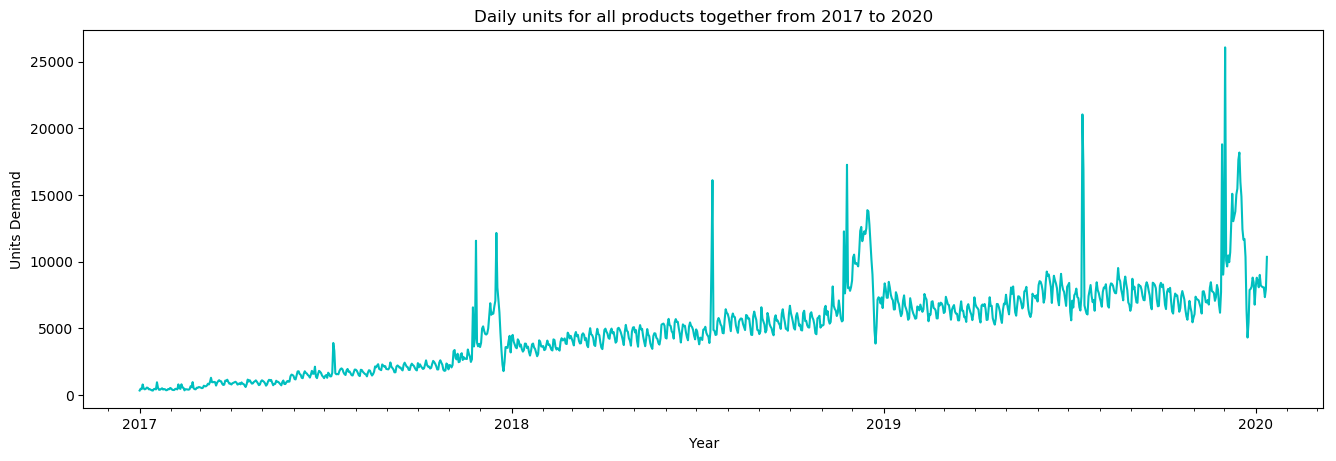

In [50]:
years = mdates.YearLocator(base=1,month=1,day=1)
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y') 
months_fmt = mdates.DateFormatter('%b')

plt.figure(figsize=(16,5), dpi=100)
plt.plot(combined_dataset['Date'], combined_dataset['Units'], color='c')
X = plt.gca().xaxis
X.set_major_locator(years)
X.set_major_formatter(years_fmt)
X.set_minor_locator(months)
# X.set_minor_formatter(months_fmt)
plt.gca().set(title='Daily units for all products together from 2017 to 2020', xlabel='Year', ylabel='Units Demand')

plt.show()

2. #### In order to apply ARIMA or any models to be able to foreacast, we want to check if the timeseries is stationary by using a Dickey-Fuller test which provides quantitative results.

In [51]:
combined_data =  combined_dataset[['Date','Units']] 
combined_ts = combined_data.set_index('Date')
combined_ts.head()

,Units
Date,
2017-01-01,340
2017-01-02,477
2017-01-03,437
2017-01-04,794
2017-01-05,490


In [52]:
adf_result = adfuller(combined_ts['Units'].values, autolag='AIC')
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
for key, value in adf_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.0842386970362066
p-value: 0.25089934573201134
Critial Values:
   1%, -3.436358022565693
Critial Values:
   5%, -2.8641928088747743
Critial Values:
   10%, -2.5681824424400626


#### Results evaluation: Looking at the results above, the ADF statistic result is not lower than any of the Critical Values and also the p-value is 0.25 which is quite high. Thus we can conclude that our dataset is non-stationary.

#### 3. Plotting AutoCorrelation Plot:

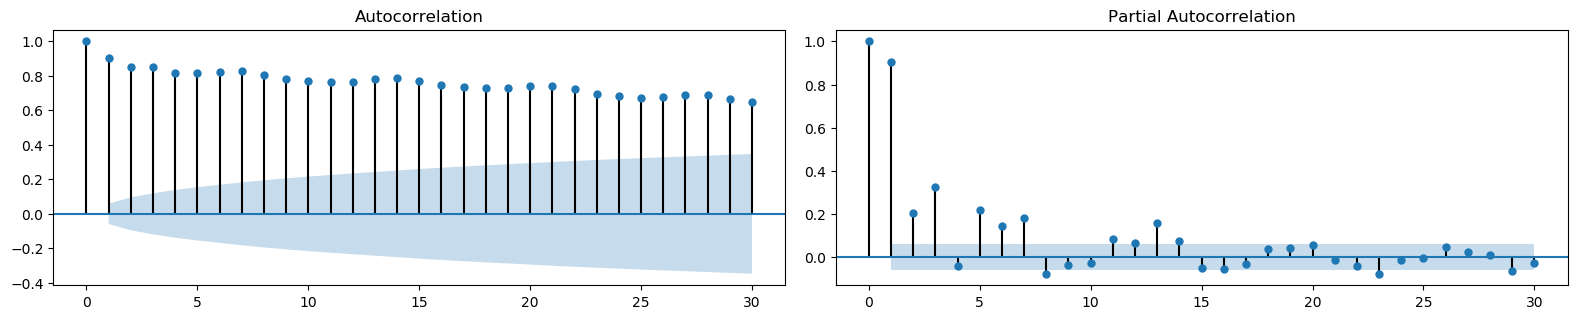

In [53]:
fig = plt.figure(figsize=(16,6), dpi= 100)
layout = (2,2)
acf_ax = plt.subplot2grid(layout, (1,0))
pacf_ax = plt.subplot2grid(layout, (1,1))

plot_acf(combined_ts['Units'].tolist(), lags=30, ax=acf_ax)
plot_pacf(combined_ts['Units'].tolist(), lags=30, ax=pacf_ax)
plt.tight_layout()

#### Results evaluation: We can see that the correlation is high in this time series and there is also a bit of seasonality observed here. We take the first difference to get rid of the high correlation & make the data stationary.

In [54]:
data_diff = combined_ts['Units'] - combined_ts['Units'].shift(1)
data_diff = data_diff[1:]


In [55]:
data_diff_df = pd.DataFrame({'Date': data_diff.index, 'Units':data_diff.values})
data_diff_df.tail()

,Date,Units
1101,2020-01-08,-56.0
1102,2020-01-09,-8.0
1103,2020-01-10,-733.0
1104,2020-01-11,589.0
1105,2020-01-12,2432.0


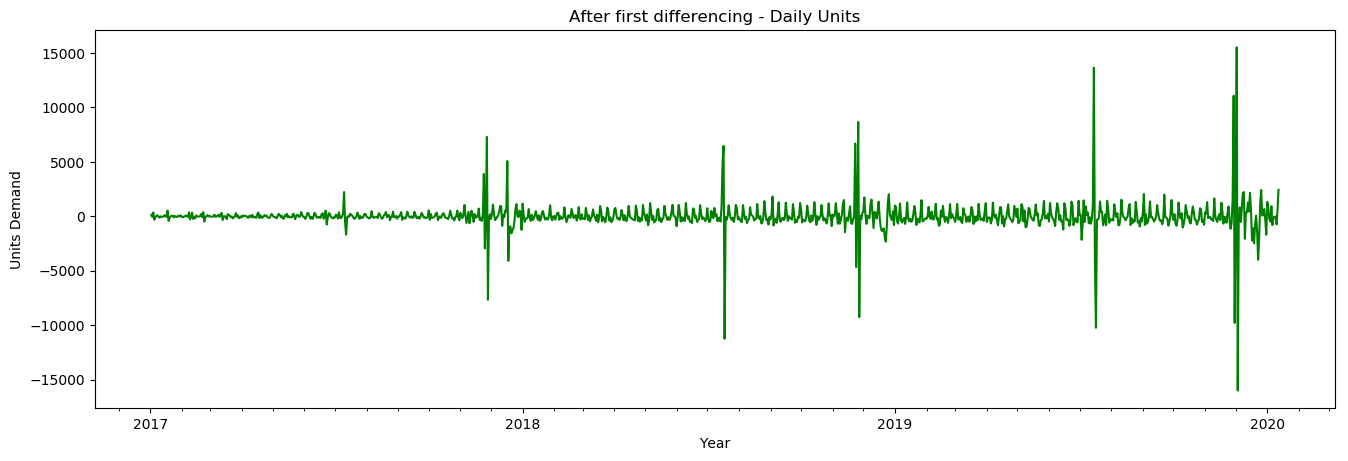

In [56]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(data_diff_df['Date'], data_diff_df['Units'], color='g')
X = plt.gca().xaxis
X.set_major_locator(years)
X.set_major_formatter(years_fmt)
X.set_minor_locator(months)
# X.set_minor_formatter(months_fmt)
plt.gca().set(title='After first differencing - Daily Units', xlabel='Year', ylabel='Units Demand')

plt.show()

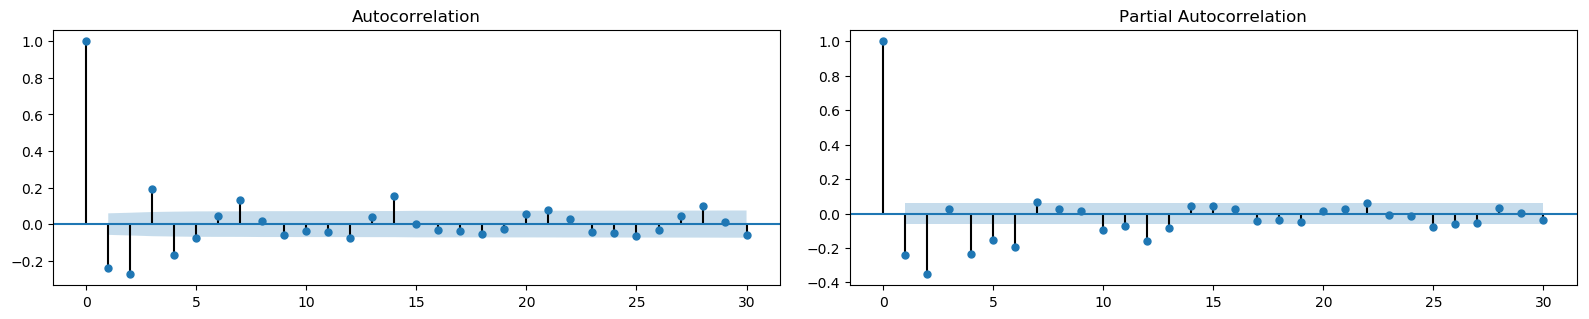

In [57]:
fig = plt.figure(figsize=(16,6), dpi= 100)
layout = (2,2)
acf_ax = plt.subplot2grid(layout, (1,0))
pacf_ax = plt.subplot2grid(layout, (1,1))

plot_acf(data_diff[1:], lags=30, ax=acf_ax)
plot_pacf(data_diff[1:], lags=30, ax=pacf_ax)
plt.tight_layout()

In [58]:
adf_result_diff = adfuller(data_diff_df['Units'].values, autolag='AIC')
print(f'ADF Statistic: {adf_result_diff[0]}')
print(f'p-value: {adf_result_diff[1]}')
for key, value in adf_result_diff[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -11.385973135592955
p-value: 8.288538495150398e-21
Critial Values:
   1%, -3.436358022565693
Critial Values:
   5%, -2.8641928088747743
Critial Values:
   10%, -2.5681824424400626


#### Results Evaluation: Fantastic! After first differencing our dataset has become stationary, and we have validated it using ACF plots, ADF test and plot of the Units

In [59]:
model_p1d1q2 = ARIMA(combined_train_set['Units'], order=(1,1,2))
model_p1d1q2_fit = model_p1d1q2.fit(disp=0)
print(model_p1d1q2_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Units   No. Observations:                  995
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -8247.393
Method:                       css-mle   S.D. of innovations            962.420
Date:                Mon, 17 Feb 2020   AIC                          16504.787
Time:                        14:54:22   BIC                          16529.301
Sample:                             1   HQIC                         16514.106
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.3761      6.825      1.081      0.280      -6.000      20.753
ar.L1.D.Units     0.0099      0.088      0.113      0.910      -0.162       0.182
ma.L1.D.Units    -0.3304      0.082     

In [60]:
p1d1q2_arima_predictions = model_p1d1q2_fit.forecast(steps=111)[0]
p1d1q2_arima_rmse = calculate_rmse(combined_test_set['Units'],list(p1d1q2_arima_predictions))
print("The RMSE for ARIMA (p1d1q2) is: ",np.round(p1d1q2_arima_rmse,0), " units")

The RMSE for ARIMA (p1d1q2) is:  3207.0  units


### Inference from ARIMA:

1. We can see that RMSE after using ARIMA is quite similar to results from moving averages. Another important note is that the p-value for the AR part of this model is really high, thus confirming that linear is not a significant aspect in this dataset for generating forecasts.